# In this notebook we will train a simple neural network to identify galaxy clusters in CMB maps using the SZ Effect.
### We will compare the output of that neural network with the standard matched filter approach

In [1]:
import numpy as np, sys, os, scipy as sc
import tensorflow as tf
import BasicClusterFunctions as clu
import pylab as pl
#Import Srinivasan Raghunathan's code for making simulated maps of the CMB
#https://github.com/sriniraghunathan/cmb_T_of_z
data_folder = '/Users/milokorman/cmb_T_of_z/python/data/'
sys_path_folder = '/Users/milokorman/cmb_T_of_z/python/'
sys.path.append(sys_path_folder)
import flatsky_routines as flatsky, misc_tools as tools, foregrounds as fg
%load_ext autoreload
%autoreload 2

2023-03-07 20:03:28.291488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import copy

### First, set up the parameters for the simulated maps

In [3]:
#input parameters
#CMB CLs
Cls_file = '%scamb/planck18_TTEEEE_lowl_lowE_lensing_highacc/planck2018_base_plikHM_TTTEEE_lowl_lowE_lensing_lensedCls.dat' %(data_folder)
#Cluster core size, just using smallest core size
tcs = np.array([.25])
#pixel size in arcminutes
dx = .25
boxsize_am = 20. #boxsize in arcmins
ny = nx = int(boxsize_am/dx)
mapparams = [ny, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx
freq_arr=[150]
fsz=clu.calc_fsz(150)
noise_val_dict = {150: 3.92} #uK-arcmin
beam_val_dict = {150: 1.19} #arcmins
resrad=dx*0.000290888
#1/f definitions
el_knee_dic = {90: 1200., 150: 2200., 220: 2300.}
alpha_knee_dic = {90: 3., 150: 4., 220: 4.}
lpf=None
isohpf=None

## Read in astrophysical cls and cluster profiles

In [4]:
#read in astrophysical cls (the only ones we actually use are tt)
el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(Cls_file, unpack = 1)
dl_all = np.asarray( [dl_tt, dl_ee, dl_bb, dl_te] )
cl_tt = clu.dl_to_cl(el, dl_all[0])
cl = cl_tt
cl_dic = {}
cl_dic['TT'] = cl_tt
profiles=np.load('clusterprofiles.npy')[0:1]#l space cluster profiles, coresize = 1 arcmin
profile_ls=np.arange(80001)

In [5]:
#get beam and noise
bl_dict, nl_dict = {}, {}
for freq in freq_arr:
    beamval, noiseval = beam_val_dict[freq], noise_val_dict[freq]
    bl = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)
    nl = tools.get_nl(noiseval, el, elknee_t = el_knee_dic[freq], alpha_knee = alpha_knee_dic[freq])
    nl_dict[freq] = nl
    bl_dict[freq] = bl

In [6]:
#get foregrounds
cl_fg_dic = {}
for freq in freq_arr:
    cl_fg_dic[freq] = tools.get_cl_fg(el = el, freq = freq)['T']
print(cl_fg_dic.keys())

dict_keys([150])


### Make and plot an example simulated CMB+Foreground map

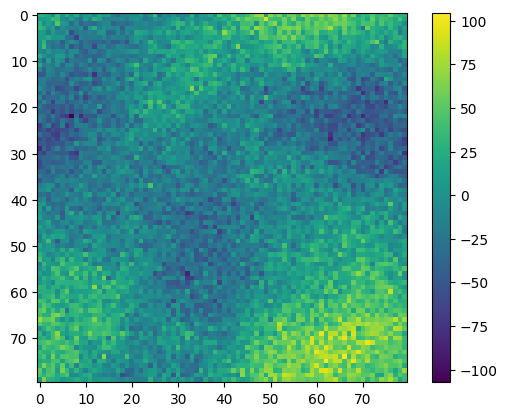

In [7]:
#create CMB and convolve with beam
cmb_map_dict, fg_map_dict = {}, {}
for freq in freq_arr:
    cmb_map = flatsky.make_gaussian_realisation(mapparams, el, cl, bl = bl_dict[freq])
    fg_map = flatsky.make_gaussian_realisation(mapparams, el, cl_fg_dic[freq], bl = bl_dict[freq])
    cmb_map_dict[freq] = cmb_map
    fg_map_dict[freq] = fg_map

#noise map
noise_map_dict = {}
for freq in freq_arr:
    noise_map = flatsky.make_gaussian_realisation(mapparams, el, nl_dict[freq])
    noise_map_dict[freq] = noise_map

#add all components now
sim_map_dict = {}
for freq in freq_arr:
    sim_map_dict[freq] = cmb_map_dict[freq] + fg_map_dict[freq] + noise_map_dict[freq]

#make plot of simulated map
pl.clf()
fsval = 8
sbpl = 1
pl.imshow(sim_map_dict[150])
pl.colorbar()
pl.show()


### create normalized cluster template

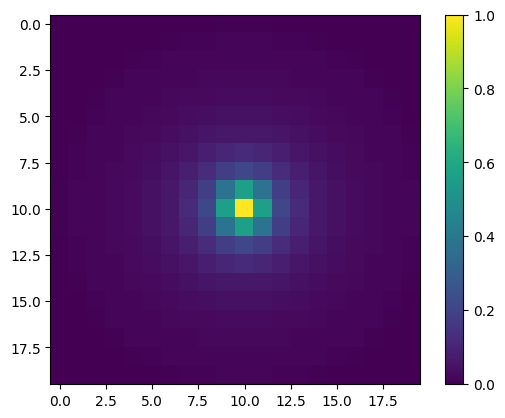

In [8]:
#create template clusters for insertion
#creates a dictionary of templates, one for each core size
#here, we are only using the smallest core size
mid=int(nx/2)
cutwidth=20
cutouts={}
for i in range(0,len(tcs)):
    profile_ft=clu.gridtomap(clu.ell_grid(dx,ny,nx),profiles[i],profile_ls)
    real_profile=np.fft.fftshift(np.fft.ifft2(profile_ft,norm='ortho')).real
    real_profile/=np.max(real_profile)
    cutout=real_profile
    cutouts[tcs[i]]=cutout[mid-int(cutwidth/2):mid+int(cutwidth/2),mid-int(cutwidth/2):mid+int(cutwidth/2)]
pl.imshow(cutouts[.25])
pl.colorbar()
pl.show()

In [9]:
nx

80

In [10]:
print(np.shape(cutouts[.25]))
print(np.shape(sim_map_dict[150]))

(20, 20)
(80, 80)


### Now we can create arrays of training and test data 
### We will create 1000 simulated maps, with and without clusters inserted at random locations

In [11]:
fsz

-0.9529784143018918

In [12]:
N_train=1000
N_test=200
use_cmb=True
train_maps=np.zeros((N_train,nx ,nx))
train_labels=np.zeros(N_train)
test_maps=np.zeros((N_test,nx ,nx))
test_labels=np.zeros(N_test)
xlocs=np.zeros(N_test)
ylocs=np.zeros(N_test)
yvals=np.zeros(N_test)
for i in range(0,N_train):
    if i%200==0:
        print(i)
    #create CMB+noise+foregrounds and convolve with beam
    if use_cmb:
        cmb_map = flatsky.make_gaussian_realisation(mapparams, el, cl, bl = bl_dict[150])
        fg_map = flatsky.make_gaussian_realisation(mapparams, el, cl_fg_dic[150], bl = bl_dict[150])
        noise_map = flatsky.make_gaussian_realisation(mapparams, el, nl_dict[150])
        sim_map=cmb_map+fg_map+noise_map
        sim_map=sim_map-np.min(sim_map)
    else:
        sim_map=np.zeros((nx,nx))
    cluster=np.random.binomial(1,.5)
    if cluster:
        yval=np.random.uniform(5,200)*2.73
        xloc=int(np.random.uniform(cutwidth,nx-cutwidth))
        yloc=int(np.random.uniform(cutwidth,nx-cutwidth))
        sim_map[yloc-int(cutwidth/2):yloc+int(cutwidth/2),
                xloc-int(cutwidth/2):xloc+int(cutwidth/2)]+=(cutouts[.25]*yval)
    sim_map=sim_map/np.max(sim_map)
    train_maps[i]=sim_map
    train_labels[i]=float(cluster)
for i in range(0,N_test):
    if i%50==0:
        print(i)
    #create CMB+noise+foregrounds and convolve with beam
    if use_cmb:
        cmb_map = flatsky.make_gaussian_realisation(mapparams, el, cl, bl = bl_dict[150])
        fg_map = flatsky.make_gaussian_realisation(mapparams, el, cl_fg_dic[150], bl = bl_dict[150])
        noise_map = flatsky.make_gaussian_realisation(mapparams, el, nl_dict[150])
        sim_map=cmb_map+fg_map+noise_map
        sim_map=sim_map-np.min(sim_map)
    else:
        sim_map=np.zeros((nx,nx))#cmb_map+fg_map+noise_map
    cluster=np.random.binomial(1,.5)
    yval=0
    if cluster:
        yval=np.random.uniform(5,200)*2.73
        xloc=int(np.random.uniform(cutwidth,nx-cutwidth))
        yloc=int(np.random.uniform(cutwidth,nx-cutwidth))
        sim_map[yloc-int(cutwidth/2):yloc+int(cutwidth/2),
                xloc-int(cutwidth/2):xloc+int(cutwidth/2)]+=(cutouts[.25]*yval)
    test_maps[i]=sim_map
    test_labels[i]=float(cluster)
    xlocs[i]=xloc
    ylocs[i]=yloc
    yvals[i]=yval

0
200
400
600
800
0
50
100
150


In [13]:
test_maps_NN=np.array([test_maps[i]-np.min(test_maps[i]) for i in range(0,N_test)])
test_maps_NN=np.array([test_maps_NN[i]/np.max(test_maps_NN[i]) for i in range(0,N_test)])

In [14]:
# i=9
# fig,axes=pl.subplots(nrows=1,ncols=2)
# c1=axes[0].imshow(test_maps[i])
# c2=axes[1].imshow(test_maps[i+1])
# print()
# fig.colorbar(c2,orientation='horizontal')
# fig.colorbar(c1,orientation='horizontal')

# pl.show()
# print(yvals[i],yvals[i+1])

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_maps, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_maps_NN, test_labels))

2023-03-07 20:03:43.997501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100

# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)

### Now we can create the model

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(nx, nx)),
#    tf.keras.layers.Dropout(rate=.01),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               819328    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 819,586
Trainable params: 819,586
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.fit(train_maps, train_labels, epochs=10)


Epoch 1/10
32/32 [==============================] - 1s 14ms/step - loss: 0.7797 - accuracy: 0.6950
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 0.5069 - accuracy: 0.8280
Epoch 3/10
32/32 [==============================] - 1s 16ms/step - loss: 0.4593 - accuracy: 0.8420
Epoch 4/10
32/32 [==============================] - 0s 14ms/step - loss: 0.5242 - accuracy: 0.7600
Epoch 5/10
32/32 [==============================] - 0s 14ms/step - loss: 0.4823 - accuracy: 0.8130
Epoch 6/10
32/32 [==============================] - 0s 14ms/step - loss: 0.5369 - accuracy: 0.7750
Epoch 7/10
32/32 [==============================] - 0s 15ms/step - loss: 0.5058 - accuracy: 0.8010
Epoch 8/10
32/32 [==============================] - 1s 16ms/step - loss: 0.4902 - accuracy: 0.8220
Epoch 9/10
32/32 [==============================] - 1s 16ms/step - loss: 0.4726 - accuracy: 0.8010
Epoch 10/10
32/32 [==============================] - 1s 16ms/step - loss: 0.4868 - accuracy: 0.8030


In [21]:
test_loss, test_acc = model.evaluate(test_maps_NN,  test_labels, verbose=2)


7/7 - 0s - loss: 0.4977 - accuracy: 0.7800 - 226ms/epoch - 32ms/step


In [22]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [23]:
predictions=probability_model.predict(test_maps_NN)


7/7 [==============================] - 0s 3ms/step


In [24]:
count=0
for i in range(0,len(test_labels)):
    if np.argmax(predictions[i])==(test_labels[i]):
        count+=1
print(count/N_test)
    

0.78


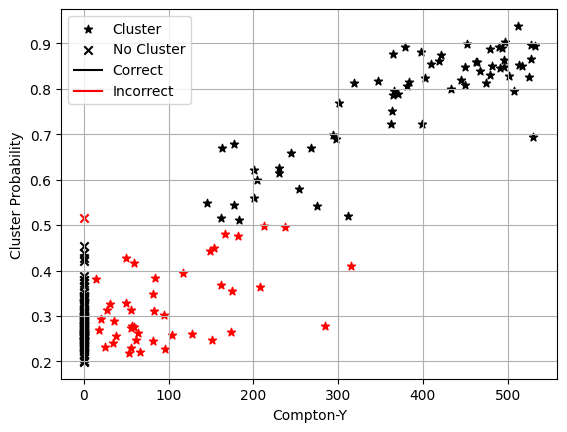

In [25]:
for i in range(0,N_test):
    color='red'
    marker='x'
    if test_labels[i]==1:
        marker='*'
    if np.argmax(predictions[i])==(test_labels[i]):
        color='black'
    pl.scatter(yvals[i],predictions[i][1],color=color,marker=marker)
pl.ylabel('Cluster Probability')
pl.xlabel('Compton-Y')
pl.scatter([],[],marker='*',label='Cluster',color='black')
pl.scatter([],[],marker='x',label='No Cluster',color='black')
pl.plot([],[],color='black',label='Correct')
pl.plot([],[],color='red',label='Incorrect')
pl.grid()
pl.legend()

### Now lets make the matched filter to use for the comparison

In [26]:
#need this for plotting and making the filter
ell_min = 0
ell_max = np.pi / (resrad)
delta_ell = 2 * np.pi / (np.max([nx,ny]) * resrad)
ell_bins = np.arange(ell_min, ell_max + delta_ell, delta_ell)
ell_plot=(np.array(ell_bins[1:]) + np.array(ell_bins[:-1]))/2

In [27]:
#create astro covariance matrix for filter
ncov1d=clu.create_ncov1d([el,el],
                         [cl,cl_fg_dic[150]],
                         ell_max,
                         1)

In [28]:
#set up instrument noise component for filter
ncl=np.min(nl_dict[150])
noise_cls=ncl*np.ones(80001)
noise_cls[:len(nl_dict[150])]=nl_dict[150]
noise_els=np.arange(80001)
whitenoise=clu.gridtomap(clu.ell_grid(dx,ny,nx),noise_cls,noise_els)
nmatinst=clu.create_N_d(
    [whitenoise])

In [29]:
#combine instrument / astro noise to make full covariance matrix
nmatastro=clu.create_ncovbd(ncov1d,np.array([ bl_dict[150]]),dx,1,ny,nx,ell_max)
ncovfull=nmatinst+nmatastro

[80, 80, 1, 1]


In [30]:
ft_signal=np.stack([profile_ft *bl_dict[150]],axis=2)
psi,sigma=clu.psi_faster([1],ft_signal,ncovfull,ny,nx,1)

In [31]:
matched_sns=np.zeros(N_test)
for i in range(N_test):
    fmap=clu.multi_band_filter([test_maps[i]],psi,dx,1)
    sig=clu.ndh_sigma(fmap,None,None)
    sn=np.max(fmap/sig)
    matched_sns[i]=sn


In [32]:
NN_probs=predictions[:, 1]

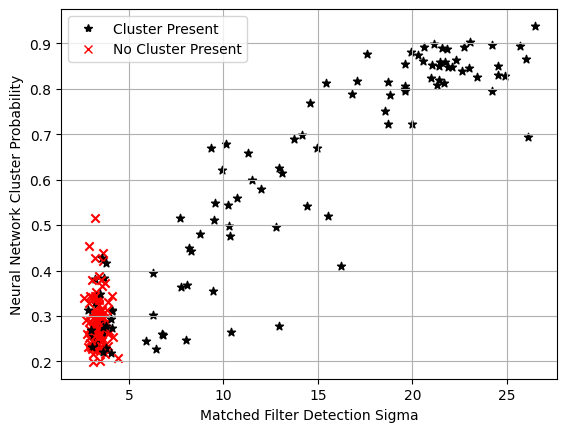

In [33]:
for i in range(0,N_test):
    marker='x'
    color='red'
    if test_labels[i]:
        color='black'
        marker='*'
    pl.scatter(matched_sns[i],NN_probs[i],marker=marker,color=color)
pl.grid()
pl.xlabel('Matched Filter Detection Sigma')
pl.ylabel('Neural Network Cluster Probability')
pl.plot([],[],linestyle='none',marker='*',color='black',label='Cluster Present')
pl.plot([],[],linestyle='none',marker='x',color='red',label='No Cluster Present')
pl.legend()
pl.show()

In [35]:
(2754-89)/7

380.7142857142857